In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sim_steady_state_fast as sim
import sim_fake_news

In [2]:
# for plotting: uncomment second line to get plots with exact style
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (6, 3)})
plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

# Structure of this notebook
This notebook first develops the figures in the lecture 3 slides, with a bit of added material—for instance, showing that analytical moments agree with simulation moments, and providing a fast FFT-based function for calculating analytical moments.

Then, at the end, it explicitly implements the fake news algorithm to calculate $\mathbf{M}$. This code is generalized in `sim_fake_news.py` to allow it to be calculated with respect to more shocks.

# Preliminary: same beta-heterogeneity calibration from lecture 1
See lecture 1 notebook for details!

Load core calibration:

In [3]:
rho_e = 0.91**(1/4)     # annual rho=0.91 from IKC
sd_e = 0.92             # cross-sectional sd from IKC
n_e = 11                # 11 points for Rouwenhorst approximation

e, pi_e, Pi_e = sim.discretize_income(rho_e, sd_e, n_e)

min_a = 0               # borrowing constraint of 0 (no borrowing)
max_a = 4000
n_a = 400
a_grid = sim.discretize_assets(min_a, max_a, n_a)

r = 0.02/4              # annual r=2% from ARE
beta = 0.985            # arbitrary discount factor prior to exact calibration
eis = 1                 # elasticity of intertemporal substitution = 1 (log utility)

calib = dict(a_grid=a_grid, r=r, eis=eis)

Add $\beta$ heterogeneity:

In [4]:
# transition matrix
q = 0.01        # draw new beta every 25 years
pi_b = np.array([1/4, 1/4, 1/4, 1/4])
Pi_b = (1-q)*np.eye(4) + q*np.outer(np.ones(4), pi_b)

# combined state process, income
Pi = np.kron(Pi_b, Pi_e)
e = np.kron(np.ones(4), e)
calib.update({'Pi': Pi, 'y': 0.7*e})

# calibrated betas from lecture 1
beta_hi, dbeta = 1.0022888126270926, 0.019261748244610084
beta = np.kron([beta_hi-3*dbeta, beta_hi-2*dbeta, beta_hi-dbeta, beta_hi], np.ones(n_e))[:, np.newaxis]
calib['beta'] = beta

Calculate steady state:

In [5]:
ss = sim.steady_state(**calib)

# Visualize intertemporal MPCs
We'll use the `sim_fake_news.jacobian()` function for these; we'll compute $\mathbf{M}$ on our own following the steps of the fake news algorithm at the end of this notebook.

In [6]:
T = 500
Js = sim_fake_news.jacobian(ss, {'Z': {'y': e}}, T=T) # y = Z*e, so dZ changes y in proportion to e
M, A = Js['C']['Z'], Js['A']['Z']

Manually calculate intertemporal MPCs like before:

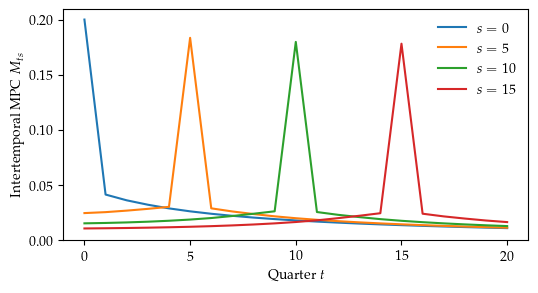

In [7]:
for s in (0, 5, 10, 15):
    plt.plot(M[:21, s], label=fr'$s={s}$')
plt.xlabel(r'Quarter $t$')
plt.xticks([0, 5, 10, 15, 20])
plt.yticks([0, .05, .10, .15, .20])
plt.ylabel(r'Intertemporal MPC $M_{ts}$')
plt.legend(frameon=False)
plt.savefig("figures/lecture3_fig1.pdf", transparent=True, bbox_inches='tight')

# Fake news matrix visualization

In [8]:
F = M.copy()
F[1:, 1:] -= M[:-1, :-1]        # F_(t,s) = M_(t,s) - M_(t-1,s-1)

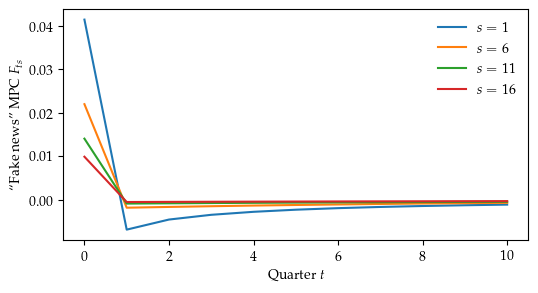

In [9]:
for s in (1, 6, 11, 16):
    plt.plot(F[:11, s], label=fr'$s={s}$')
plt.xlabel(r'Quarter $t$')
plt.ylabel(r'``Fake news" MPC $F_{ts}$')
plt.legend(frameon=False)
plt.savefig("figures/lecture3_fig2.pdf", transparent=True, bbox_inches='tight')

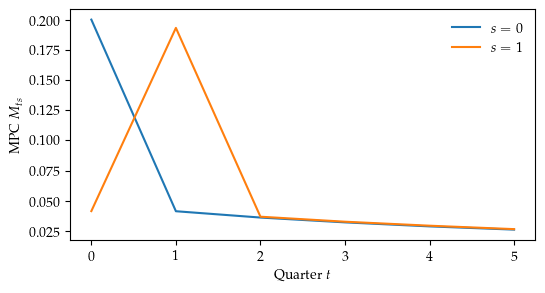

In [10]:
for s in (0, 1):
    plt.plot(M[:6, s], label=fr'$s={s}$')
plt.xlabel(r'Quarter $t$')
plt.ylabel(r'MPC $M_{ts}$')
plt.legend(frameon=False)
plt.savefig("figures/lecture3_fig3.pdf", transparent=True, bbox_inches='tight')

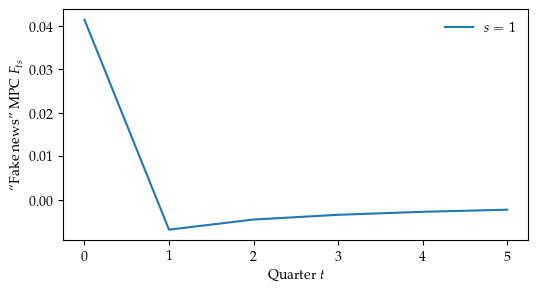

In [11]:
for s in (1,):
    plt.plot(F[:6, s], label=fr'$s={s}$')
plt.xlabel(r'Quarter $t$')
plt.ylabel(r'``Fake news" MPC $F_{ts}$')
plt.legend(frameon=False)
plt.savefig("figures/lecture3_fig4.pdf", transparent=True, bbox_inches='tight')

# Sequence space solutions

First let's imagine an arbitrary deficit-financed tax cut shock, similar to that in the Annual Review paper. The idea is that there's a negative AR(1) impulse to desired taxes, but that the government tries to bring debt back to its steady-state target.

In [12]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB, dT = np.empty_like(dT_shock), np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
dT[0] = dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]
    dT[t] = (1+r)*dB[t-1] - dB[t]


Solve the asset-space IKC to get the impulse response to this shock, then plot:

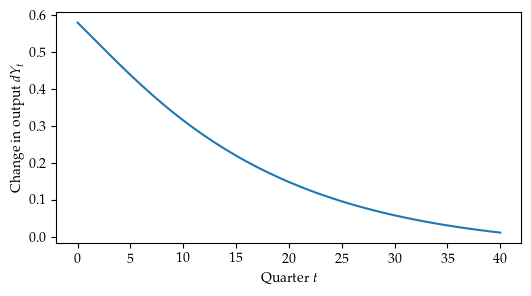

In [13]:
dY = np.linalg.solve(A, dB) + dT

plt.plot(dY[:41])
plt.xlabel(r'Quarter $t$')
plt.ylabel(r'Change in output $dY_t$')
plt.savefig("figures/lecture3_fig4.pdf", transparent=True, bbox_inches='tight')

## Simulation
Now let's suppose that this impulse to the path of taxes happens every period $t$, in proportion to some $\epsilon_t$ with standard deviation $\sigma$. We can stitch together the impulse response to the MIT shock to get the simulated path, following Boppart Krusell Mitman and the SSJ paper:

In [14]:
sigma = 0.005
Tsim = 1_000_000                # will simulate for 1 million quarters
np.random.seed(40)
eps = np.random.randn(Tsim+T)   # draw epsilons for T additional pre-periods so that we have a full set of epsilons
dY_sim = np.empty(Tsim)
for t in range(Tsim):
    # at each t, take window of current up to T-1 previous epsilons
    # take dot product with MA coefficients implied by MIT shock
    dY_sim[t] = np.dot(dY, eps[t:t+T][::-1]) * sigma

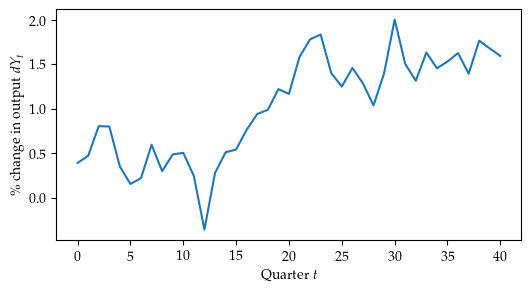

In [15]:
plt.plot(100*dY_sim[:41])
plt.xlabel(r'Quarter $t$')
plt.ylabel(r'\% change in output $dY_t$')
plt.savefig("figures/lecture3_fig5.pdf", transparent=True, bbox_inches='tight')

## Analytical second moments
Formula from slides:

$$
\text{Cov}(dY_t,dY_{t'}) = \sigma^2 \sum_{s=0}^\infty \frac{\partial Y}{\partial \epsilon_s} \frac{\partial Y}{\partial \epsilon_{s+t'-t} }
$$

Start with simple case of $t=t'$ to get variance. Here we just take the sum of the impulse response squared:

In [16]:
var_dY = sigma**2 * (dY @ dY)

Compare to the sample variance to make sure this is right. Note that it's close but not exact, reflecting Monte Carlo error:

In [17]:
sample_var_dY = (dY_sim - dY_sim.mean()) @ (dY_sim - dY_sim.mean()) / Tsim
sample_var_dY, var_dY

(7.086997080198989e-05, 7.13267548319846e-05)

What about the covariance at a horizon of 20 quarters? Then, following formula above, we take the dot product of the impulse response and itself lagged 20 quarters:

In [18]:
cov_20_dY = sigma**2 * (dY[:-20] @ dY[20:])

Compare to sample covariance. Again, very similar, but not identical:

In [19]:
sample_cov_20_dY = (dY_sim[:-20] - dY_sim.mean()) @ (dY_sim[20:] - dY_sim.mean()) / Tsim
sample_cov_20_dY, cov_20_dY

(1.5123611368385219e-05, 1.5312667920677813e-05)

At a horizon of 20 quarters, autocorrelation is about 0.2:

In [20]:
cov_20_dY / var_dY

0.2146833675070165

#### Detail: efficiently calculating all with Fast Fourier Transform
Here's a function that calculates autocovariances at every horizon up to $T$ simultaneously using the Fast Fourier Transform, given a length-$T$ impulse response in `a`. For generality, we allow `a` to be $T \times n_Y \times n_\epsilon$, where $n_Y$ is the number of different outputs of interest (here, just aggregate output), and $n_\epsilon$ is the number of different shocks (here, just a single shock that triggers the tax cut impulse).

Note: `a` here is intended to include $\sigma$.

In [21]:
def autocovariances_fft(a):
    T = len(a)
    dft = np.fft.rfftn(a, s=(2 * T - 1,), axes=(0,))
    total = dft.conjugate() @ dft.swapaxes(1, 2)
    return np.fft.irfftn(total, s=(2 * T - 1,), axes=(0,))[:T]

Let's test it on our single-output, single-shock case, comparing to what we already calculated. Usually takes a millisecond or less (and scales well for larger $T$ or more outputs and inputs):

In [22]:
a = (sigma*dY)[:, np.newaxis, np.newaxis] # add trailing singleton dimensions since nY, neps = 1, 1
%time covs = autocovariances_fft(a)[:, 0, 0]

CPU times: user 1.27 ms, sys: 23 µs, total: 1.29 ms
Wall time: 85.8 µs


Validate that this gives the same answer in the cases we've already calculated:

In [23]:
covs[0] - var_dY, covs[20] - cov_20_dY

(0.0, 3.3881317890172014e-21)

# Fake news algorithm for intertemporal MPCs
This is generalized by `sim_fake_news.py` to allow for arbitrary shocks (rather than just to $Z$ here) and also to obtain the Jacobians for both assets and consumption in response to those shocks (rather than just $C$ here).

**Step 1: backward iteration.** First, iterate backward in response to a small shock to income, and store the $\mathcal{Y}_s$ (how does the consumption policy change in response to income in $s$ periods affect aggregate consumption today?) and $\mathcal{D}_s$ (how does the asset policy change in response to income in $s$ periods affect the distribution going into tomorrow?).

In [24]:
# preliminaries: get steady-state inputs, allocate arrays for curlyY and curlyD
ss_inputs = {k: ss[k] for k in ('Va', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis')}
curlyY = np.empty(T)
curlyD = np.empty((T,) + ss['D'].shape)

# slight numerical robustness: what does forward iteration give without shock?
D1_noshock = sim.forward_iteration(ss['D'], ss['Pi'], ss['a_i'], ss['a_pi'])

h = 1E-4
for s in range(T):
    if s == 0:
        # Z shock today, so tomorrow's Va is steady state, and we change income
        Va, a, c = sim.backward_iteration(**{**ss_inputs, 'y': ss['y'] + h*e})
    else:
        # Z shock in future, so income is steady state, take in last Va
        Va, a, c = sim.backward_iteration(**{**ss_inputs, 'Va': Va})
    
    # aggregate effect on C
    curlyY[s] = np.vdot(ss['D'], c - ss['c']) / h

    # what is effect on one-period-ahead distribution?
    a_i_shocked, a_pi_shocked = sim.interpolate_lottery_loop(a, ss['a_grid'])
    curlyD[s] = (sim.forward_iteration(ss['D'], ss['Pi'], a_i_shocked, a_pi_shocked) - D1_noshock) / h

**Step 2: expectation iteration.**
Expectation iterations are already defined in `sim_steady_state.py` and `sim_steady_state_fast.py`, and explained in the supplementary notebook `sim_steady_state_computation.ipynb` (and video lectures).

These correspond to repeatedly taking one-period-ahead expectations using the steady-state transition matrix across states $(e,a)$, starting with whatever our outcome of interest is—in this case, consumption. (Though the matrix is never explicitly constructed; it's better to leave implicit.)

In [25]:
curlyE = sim.expectation_functions(ss['c'], ss['Pi'], ss['a_i'], ss['a_pi'], T-1)

**Step 3: form fake news matrix.**

In [26]:
F = np.empty((T, T))
    
# t=0: F[0, s] = curlyY[o][s] for all s
F[0, :] = curlyY

# t>0: F[t, s] = dot product of curlyE[t-1] with curlyD[s]
# can write this as following (easier to read):
# for t in range(1, T):
#     for s in range(T):
#         F[o][t, s] = np.vdot(curlyE[o][t-1], curlyD[s])

# but for efficiency, we write as an equivalent single matrix multiplication instead
F[1:, :] = curlyE.reshape(T-1, -1) @ curlyD.reshape(T, -1).T

**Step 4: build up from fake news matrix to Jacobian.** Here, we implement the recursion $M_{t,s} = F_{t,s} + M_{t-1,s-1}$.

In [27]:
Mnew = F.copy()
for s in range(1, T):
    Mnew[1:, s] += Mnew[:-1, s-1]  # M_(t,s) = F_(t,s) + M_(t-1,s-1)

Let's validate that this is the same as the `M` we already obtained with the more general `sim_fake_news.jacobian()` routine. In this case, it's literally identical:

In [28]:
np.max(np.abs(Mnew - M))

0.0